Train classifier of primary endpoint type in EUCT-NS dataset using CNB with TF-IDF Features

In [1]:
import pandas as pd

import numpy as np 
from numpy import mean, std

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import ComplementNB 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
import joblib

import nltk

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import tqdm as notebook_tqdm

import joblib

Train the classifier

In [2]:
euct_ns = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\euct_ns.csv', encoding='unicode_escape')

In [3]:
euct_ns['concat_corpus'] = euct_ns['Title']+ " " + euct_ns['Objective'] + " " + euct_ns['pr_endpoint'] + " " + euct_ns['endpoint_description']

In [4]:
euct_ns['concat_corpus'] = euct_ns['concat_corpus'].fillna('')

In [5]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(euct_ns['concat_corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [6]:
X = tfidf_df
y = euct_ns['manual_label'].values

In [7]:
joblib.dump(vectorizer, "tf_idf embeddings.pkl")

['tf_idf embeddings.pkl']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
cnb = ComplementNB()
pipeline = make_pipeline(TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3)), cnb)

joblib.dump(pipeline, "CNB_pipeline.pkl")

['CNB_pipeline.pkl']

In [10]:
cnb = ComplementNB(alpha = 1.0, fit_prior = True)

In [11]:
# Train the model on the training data
cnb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = cnb.predict(X_test)

In [12]:
joblib.dump(cnb, "model.pkl")

['model.pkl']

In [14]:
print(y_test)

[0 0 2 0 0 0 2 2 2 2 1 0 0 0 0 0 0 1 2 1 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0
 0]


In [15]:
print(y_pred) # There is no cases of intermediate outcomes in the pred set. Do I re-run it?

[0 1 2 0 0 0 2 2 2 2 0 0 1 0 2 0 2 1 0 1 0 0 1 1 2 0 0 0 2 0 2 1 1 0 0 1 2
 1]


In [30]:
accuracy_weighted = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Get the predicted probabilities
y_pred_proba = cnb.predict_proba(X_test)

# Calculate AUROC score using predicted probabilities
auroc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')

accuracy_unweighted = accuracy_score(y_test, y_pred)
classification_metrics = classification_report(y_test, y_pred, output_dict=True)

#Print metrics
print(f'Accuracy (Weighted): {accuracy_weighted:.2f}')
print(f'Precision (Weighted): {precision_weighted:.2f}, Mean={np.mean(precision_weighted):.2f} , Std={np.std(precision_weighted):.2f}')
print(f'Recall (Weighted): {recall_weighted:.2f}, Mean={np.mean(recall_weighted):.2f}, Std={np.std(recall_weighted):.2f} ')
print(f'F1 Score (Weighted): {f1_weighted:.2f}, Mean={np.mean(f1_weighted):.2f} ,Std={np.std(f1_weighted):.2f}')
print(f'AUROC (Weighted): {auroc_weighted:.2f}, Mean={np.mean(auroc_weighted):.2f}, Std={np.std(auroc_weighted):.2f}')
print()

print(f'Accuracy (Unweighted): {accuracy_unweighted:.2f}')
print("Precision, Recall, and F1 Score by Class:")
for cls, metrics in classification_metrics.items():
    if cls.isdigit():  # Filter class-specific metrics
        print(f"  Class {cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1 Score={metrics['f1-score']:.2f}")

Accuracy (Weighted): 0.58
Precision (Weighted): 0.71, Mean=0.71 , Std=0.00
Recall (Weighted): 0.58, Mean=0.58, Std=0.00 
F1 Score (Weighted): 0.61, Mean=0.61 ,Std=0.00
AUROC (Weighted): 0.75, Mean=0.75, Std=0.00

Accuracy (Unweighted): 0.58
Precision, Recall, and F1 Score by Class:
  Class 0: Precision=0.82, Recall=0.54, F1 Score=0.65
  Class 1: Precision=0.20, Recall=0.67, F1 Score=0.31
  Class 2: Precision=0.55, Recall=0.67, F1 Score=0.60


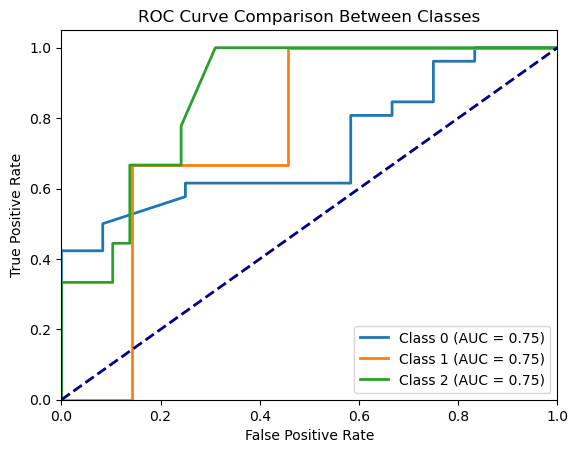

In [40]:
from sklearn.metrics import roc_curve

# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba, average = 'weighted', multi_class='ovr')

# Compute ROC curve for each class
for i in range(cnb.classes_.shape[0]):
	fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
	plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Between Classes')
plt.legend(loc="lower right")
plt.show()

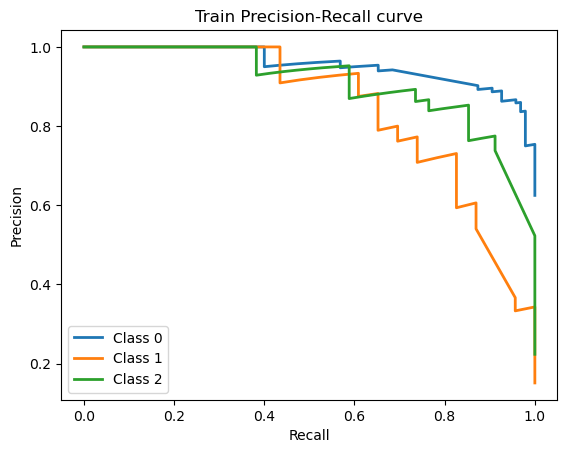

In [29]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve for each class
for i in range(cnb.classes_.shape[0]):
	y_prob_train = cnb.predict_proba(X_train)[:, i]
	y_prob_test = cnb.predict_proba(X_test)[:, i]

	precision, recall, thresholds = precision_recall_curve(y_train == i, y_prob_train)
	plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Train Precision-Recall curve")
plt.legend(loc="best")
plt.show()

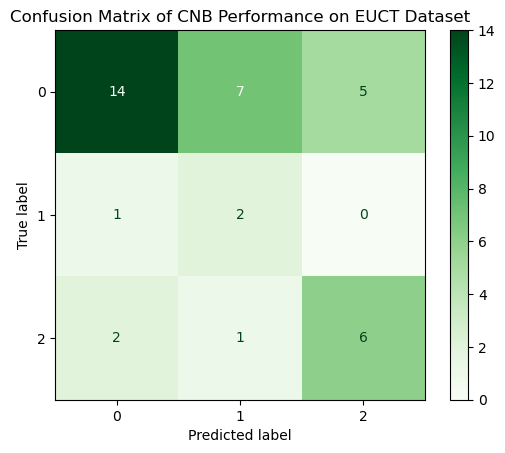

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cnb.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix of CNB Performance on EUCT Dataset')
plt.show()

Apply CNB model to NS-HRA dataset

In [13]:
ns_hra = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra.csv', encoding='unicode_escape')

In [14]:
display(ns_hra)
# Did not clean long-term follow up because it is not included in the feature set.

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjects participation in the trial is exp...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...
...,...,...,...,...,...,...,...,...,...
689,IRAS_projectID_289577,safety tolerability pharmacokinetics pharmacod...,0,primary objective trial compare safety tolerab...,21/10/2021 00:00,36.0,safety tolerability bi 1323495 assessed based ...,NaN,The Screening period of the study is 2-4 weeks...
690,IRAS_projectID_285292,phase 3 randomized double blind efficacy safet...,3,principal objective determine efficacy daily s...,27/09/2023 00:00,900.0,annualized adjudicated relapse rate number con...,NaN,The duration of the treatment period will vary...
691,IRAS_projectID_275551,phase 3 multicenter randomized double blind pl...,3,demonstrate superior efficacy treatment pf 069...,30/07/2027 00:00,99.0,change baseline week 52 north star ambulatory ...,NaN,Participants in Cohort 1 will be in the study ...
692,IRAS_projectID_290294,two part seamless multi center randomized plac...,0,primary objective study follows part 1 evaluat...,01/09/2023 00:00,231.0,endpoint part 2 change baseline total mfm 32 s...,NaN,The participant will be in the study for appro...


In [14]:
ns_hra['concat_corpus'] = ns_hra['Title']+ " " + ns_hra['Objective'] + " " + ns_hra['1ry_endpoint'] 

In [15]:
ns_hra['concat_corpus'] = ns_hra['concat_corpus'].fillna('')

In [17]:
print(ns_hra['concat_corpus'].head())

0    phase ii multicenter randomized adaptive doubl...
1    randomized controlled long term safety study e...
2    randomized double blind double dummy parallel ...
3    multi centre open label randomised trial inves...
4    use carer assisted adherence therapy people pa...
Name: concat_corpus, dtype: object


In [16]:
vectorizer = joblib.load("tf_idf embeddings.pkl")

In [20]:
print(type(vectorizer))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [17]:
X2 = vectorizer.transform(ns_hra['concat_corpus'])

In [18]:
model = joblib.load('model.pkl')

In [19]:
model.predict(X2)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ComplementNB was fitted with feature names
  warnings.warn(


array([1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 2, 1, 2,
       0, 0, 2, 0, 2, 0, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 2, 2,
       1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2, 1, 2,
       1, 0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 1,
       1, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2,
       0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 1,
       2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1,
       0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 2,
       0, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 1, 2, 0,
       0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2,
       1, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0, 2,
       2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2,

In [20]:
y_pred = model.predict(X2)

In [21]:
feature_names = vectorizer.get_feature_names_out()
X2_df = pd.DataFrame(X2.toarray(), columns=feature_names)

In [22]:
y_pred = model.predict(X2_df)
# To fix the warning above

In [23]:
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 264, 1: 196, 2: 234}


In [25]:
confidences = model.predict_proba(X2_df).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.41


In [23]:
surrogate_confidence_class_2 = model.predict_proba(X2_df.iloc[[2]])[0][2]
print(f"Confidence for predicting class 2: {surrogate_confidence_class_2:.2f}")

Confidence for predicting class 2: 0.42


In [26]:
low_confidence_indices = np.where(confidences < 0.6)[0]
print(f"Low confidence predictions: {len(low_confidence_indices)}")

Low confidence predictions: 679


Active learning

1. Least confidence sampling

In [27]:
# Define X2_unlabeled as a subset of X2 that has not been labeled yet
X2_unlabeled = X2_df  # Assuming all samples in X2_df are unlabeled

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)  # Predict probabilities for NS-HRA dataset
uncertainty_scores = 1 - probs.max(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples (e.g., N = 7)
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]  # Extract rows by indices

# Define a function to manually label the samples
def manually_label_samples(selected_rows):
    """
    Function to display Unique_ID and preprocessed concatenated text for manual labeling.

    Args:
        selected_rows: DataFrame containing rows of the dataset.

    Returns:
        List of manually labeled classes.
    """
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))  # Convert label to integer
    return labels

# Call the manual labeling function
print("Please manually label the following samples:")
y_initial = manually_label_samples(X_initial_raw)

Please manually label the following samples:
Unique_ID: IRAS_projectID_257107
Preprocessed Text: randomised clinical trial determine aesthetic outcome failure rate new compared current design resin retained bridge determine change current resin retained bridge design improve aesthetic outcome aesthetic score



Unique_ID: IRAS_projectID_234380
Preprocessed Text: multicenter randomized double blind parallel group placebo controlled study open label period evaluate efficacy safety fremanezumab prophylactic treatment migraine patient inadequate response prior preventive treatment primary objective study demonstrate efficacy fremanezumab administered monthly quarterly subcutaneous sc injection adult patient migraine inadequate response 2 4 class prior preventive treatment compared placebo efficacy endpoint mean change baseline 28 day run period monthly average number migraine day 12 week period 1st dose fremanezumab

Unique_ID: IRAS_projectID_129832
Preprocessed Text: randomised double blind placebo controlled phase iia study ass pharmacodynamics safety pharmacokinetics azd4901 given multiple dos female polycystic ovary syndrome primary objective study determine change baseline luteinising hormone lh area concentration curve time zero 8 hour postdose auc 0 8 day 7 comparison placebo change baseli

In [28]:
labeled_data = X_initial_raw.copy()
labeled_data['Label'] = y_initial

In [29]:
X2_unlabeled = X2_unlabeled.drop(index=most_uncertain_indices)

Determine best classifiers using grid search

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Define parameter grids for different classifiers
param_grids = {
    'ComplementNB': {
        'model': [ComplementNB()],
        'model__alpha': [0.1, 0.5, 1],
        'model__fit_prior': [True, False],
    },
    'SVM': {
        'model': [SVC(probability=True)],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    'RandomForest': {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    },
    'MLP': {
        'model': [MLPClassifier(max_iter=500)],
        'model__hidden_layer_sizes': [(5,), (10,), (5, 5)],
        'model__activation': ['relu', 'tanh'],
    }
}

# Define a preprocessing pipeline (e.g., scaling if needed)
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # For sparse matrices, set `with_mean=False`
    ('model', ComplementNB())  # Placeholder for the classifier
])

# Reset the indices of X2_unlabeled and most_uncertain_indices
X2_unlabeled_reset = X2_unlabeled.reset_index(drop=True)
most_uncertain_indices_reset = most_uncertain_indices % len(X2_unlabeled_reset)

# Extract initial labeled data
X_initial = X2_unlabeled_reset.iloc[most_uncertain_indices_reset]
y_initial = labeled_data['Label']

# Iterate over classifiers and parameter grids
best_models = {}
for name, param_grid in param_grids.items():
    print(f"Training {name}...")
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall_weighted', n_jobs=-1)
    grid.fit(X_initial, y_initial)
    best_models[name] = grid.best_estimator_
    print(f"Best {name} model: {grid.best_params_}")

# Choose the best classifier based on cross-validation scores
best_classifier_name = max(best_models, key=lambda x: best_models[x].score(X_initial, y_initial))
best_model = best_models[best_classifier_name]

print(f"Best overall classifier: {best_classifier_name}")

Training ComplementNB...


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best ComplementNB model: {'model': ComplementNB(), 'model__alpha': 0.1, 'model__fit_prior': True}
Training SVM...
Best SVM model: {'model': SVC(probability=True), 'model__C': 0.1, 'model__kernel': 'linear'}
Training RandomForest...


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best RandomForest model: {'model': RandomForestClassifier(), 'model__max_depth': None, 'model__n_estimators': 100}
Training MLP...


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best MLP model: {'model': MLPClassifier(max_iter=500), 'model__activation': 'tanh', 'model__hidden_layer_sizes': (5,)}
Best overall classifier: ComplementNB


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
Train the classifier

In [33]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(ns_hra['concat_corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [34]:
X = tfidf_df
y = y_initial

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
cnb = ComplementNB()
pipeline = make_pipeline(TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3)), cnb)

In [ ]:
cnb = ComplementNB(alpha = 0.1, fit_prior = True)